This notebook walks you through the process of visualizing the tables of correlations in the paper *A Powerful Hades is an Unpopular Dude: Dynamics of Power and Agency in Hades/Persephone Fanfiction* for the Conference of Computational Literary Studies 2025.

Aside from some packages imported in the next cells, you will need the csv file titled 'CCLS2025.csv' available on the project's Github repo. The csv contains metadata for the fanfiction analyzed in the paper, as well as Riveter scores for the fanfiction. Riveter was created by Maria Antoniak et al. (2023). You can learn more about Riveter on its [Github page](https://github.com/maartensap/riveter-nlp/tree/main).

## Import Requirements

In [1]:
# importing the requirements

import numpy as np
import pandas as pd
import csv
from scipy.stats import spearmanr
from datetime import datetime
import matplotlib.pyplot as plt
import IPython.display as display

## Load the data

In [2]:
df = pd.read_csv('CCLS2025.csv')

This csv is a subset of the [MythFic Metadata](https://doi.org/10.34973/2mye-8468) dataset (Neugarten & Smeets 2023). The subset was created by selecting only stories about the Hades/Persephone relationship with a length below 1,000 characters.

Note that work-ids, work titles, authors' usernames and story texts have been redacted in this version of the dataset to preserve the anonymity and privacy of the fanfiction community.

In [3]:
# check whether the data has loaded correctly
df.head()

,rating,category,fandom,relationship,character,additional tags,language,published,status,status date,...,comments,kudos,bookmarks,hits,persephone_agency,hades_agency,agency_diff,hades_power,persephone_power,power_diff
0,General Audiences,['F/F'],['Greek Mythology'],['Hades/Persephone'],"['Hades', 'Persephone', 'Libera (Ancient Roman...",['Inspired by Hades and Persephone (Ancient Gr...,English,2022-12-05,Completed,2022-12-05,...,NaN,1.0,NaN,30,NaN,NaN,NaN,NaN,NaN,NaN
1,General Audiences,['Gen'],['Ancient Greek Religion & Lore'],['Hades/Persephone (Ancient Greek Religion & L...,['Persephone (Ancient Greek Religion & Lore)'],['Drabble'],English,2022-11-14,Completed,2022-11-14,...,4.0,23.0,NaN,184,-0.285714,NaN,NaN,NaN,0.000000,NaN
2,General Audiences,['F/M'],['Ancient Greek Religion & Lore'],['Hades/Persephone (Ancient Greek Religion & L...,['Persephone (Ancient Greek Religion & Lore)'],['Drabble'],English,2022-11-06,Completed,2022-11-06,...,4.0,11.0,NaN,90,NaN,NaN,NaN,NaN,NaN,NaN
3,General Audiences,['F/F'],"['Ancient Greek Religion & Lore', 'Original Wo...",['Hera/Persephone (Ancient Greek Religion & Lo...,"['Persephone (Ancient Greek Religion & Lore)',...","['Declarations Of Love', 'Longing', 'Pining', ...",English,2022-10-31,Completed,2022-10-31,...,NaN,13.0,2.0,119,NaN,NaN,NaN,NaN,NaN,NaN
4,General Audiences,['Gen'],['Ancient Greek Religion & Lore'],['Demeter & Persephone (Ancient Greek Religion...,"['Demeter (Ancient Greek Religion & Lore)', 'P...","['Trick or Treat: Trick', 'Mother-Daughter Rel...",English,2022-10-28,Completed,2022-10-28,...,3.0,16.0,2.0,80,0.357143,0.0,-0.357143,0.2,-0.142857,0.342857


## Correlations with Violence Tags

This operationalization of violence through metadata (tags) was adapted from [Neugarten 2024](https://journal.dhbenelux.org/wp-content/uploads/2024/11/8_Neugarten_individual.pdf).

In [4]:
# creating columns that encode the occurrence of violence
df['physical violence'] = df['additional tags'].str.contains('Canon-Typical Violence|Violence|Blood|Blood and Violence|Non-Graphic Violence|Minor Violence|Torture|Cannibalism|Pain|Implied/Referenced Torture|Past Abuse', case=False, na=False).astype(int)
df['noncon'] = df['additional tags'].str.contains('Implied/Referenced Rape/Non-con|Incest|Dubious Consent|Rape/Non-con Elements|Sibling Incest|Past Rape/Non-con|Rape|Bestiality|Gang Rape|Mildly Dubious Consent|Implied/Referenced Incest', case=False, na=False).astype(int)
df['captivity'] = df['additional tags'].str.contains('Kidnapping|Abduction|Captivity|Imprisonment', case=False, na=False).astype(int)
df['death'] = df['additional tags'].str.contains('Death|Implied/Referenced Character Death|Minor Character Death|Murder|Temporary Character Death|Past Character Death', case=False, na=False).astype(int)

In [5]:
# sanity check
df.columns

Index(['rating', 'category', 'fandom', 'relationship', 'character',
       'additional tags', 'language', 'published', 'status', 'status date',
       'words', 'comments', 'kudos', 'bookmarks', 'hits', 'persephone_agency',
       'hades_agency', 'agency_diff', 'hades_power', 'persephone_power',
       'power_diff', 'physical violence', 'noncon', 'captivity', 'death'],
      dtype='object')

In [6]:
# Fill empty values with zero
df = df.fillna(0)

# Filter only relevant columns
df_violence = df.select_dtypes(include=[np.number]).drop(columns = ['words', 'comments', 'kudos', 'bookmarks', 'hits'] )

In [7]:
# This table became a figure in the paper

# Initialize correlation and p-value DataFrames with NaN values
correlations = pd.DataFrame(np.nan, index=df_violence.columns, columns=df_violence.columns)
p_values = pd.DataFrame(np.nan, index=df_violence.columns, columns=df_violence.columns)

# Calculate correlation matrix and p-values
for col1 in df_violence.columns:
    for col2 in df_violence.columns:
        if col1 != col2:  # Avoid calculating for same column pairs
            corr, p_val = spearmanr(df_violence[col1], df_violence[col2])
            correlations.loc[col1, col2] = corr
            p_values.loc[col1, col2] = p_val

# Set significance level (e.g., alpha = 0.05)
alpha = 0.05

# Filter out correlations with p-values above the significance level
significant_corr = correlations * (p_values < alpha)

significant_corr = significant_corr.dropna(how='all').dropna(axis=1, how='all')

# Display the correlation matrix with color-coding
styled_matrix = significant_corr.dropna(how='all').dropna(axis=1, how='all').style.background_gradient(cmap="coolwarm", axis=None).format(
    "{:.2f}"
)

# Display the styled matrix
display.display(styled_matrix)

,persephone_agency,hades_agency,agency_diff,hades_power,persephone_power,power_diff,physical violence,noncon,captivity,death
persephone_agency,nan,0.16,-0.23,-0.00,-0.00,-0.16,-0.00,0.10,-0.00,0.00
hades_agency,0.16,nan,0.28,-0.00,-0.09,0.00,0.00,0.00,0.00,0.00
agency_diff,-0.23,0.28,nan,0.00,-0.21,0.26,0.00,-0.00,0.00,0.00
hades_power,-0.00,-0.00,0.00,nan,0.00,0.40,0.00,0.00,0.00,0.00
persephone_power,-0.00,-0.09,-0.21,0.00,nan,-0.30,-0.00,0.00,-0.00,0.11
power_diff,-0.16,0.00,0.26,0.40,-0.30,nan,0.00,0.00,-0.00,0.00
physical violence,-0.00,0.00,0.00,0.00,-0.00,0.00,nan,0.00,-0.00,0.17
noncon,0.10,0.00,-0.00,0.00,0.00,0.00,0.00,nan,0.28,-0.00
captivity,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.28,nan,-0.00
death,0.00,0.00,0.00,0.00,0.11,0.00,0.17,-0.00,-0.00,nan


### More closely examining stories with noncon

In [8]:
# This data was reported in Table 2 in the paper

filtered_df = df[df['noncon'] == 1]
len(filtered_df)
filtered_df.head(13)

,rating,category,fandom,relationship,character,additional tags,language,published,status,status date,...,persephone_agency,hades_agency,agency_diff,hades_power,persephone_power,power_diff,physical violence,noncon,captivity,death
32,Teen And Up Audiences,"['F/M', 'Gen', 'Other']",['Ancient Greek Religion & Lore'],['Hades/Persephone (Ancient Greek Religion & L...,"['Hades (Ancient Greek Religion & Lore)', 'Nyx...","['Alternate Universe - Canon Divergence', 'Man...",English,2022-04-28,Completed,2022-04-28,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,0,0
39,Explicit,['F/F'],"['Ancient Greek Religion & Lore', 'Original Wo...",['Eurydice wife of Orpheus/Orpheus (Ancient Gr...,['Eurydice wife of Orpheus (Ancient Greek Reli...,"['Orpheus is insane', 'Inspired by Orpheus and...",English,2022-03-22,Completed,2022-03-22,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0
97,Teen And Up Audiences,['F/M'],['Ancient Greek Religion & Lore'],['Hades/Persephone (Ancient Greek Religion & L...,"['Hades (Ancient Greek Religion & Lore)', 'Per...","['Hurt/Comfort', 'Emotional Hurt/Comfort', 'Pa...",English,2021-07-08,Completed,2021-07-08,...,0.000000,0.292683,0.000000,-0.073171,0.000000,0.000000,0,1,0,0
125,Explicit,['F/M'],['Ancient Greek Religion & Lore'],['Hades/Persephone (Ancient Greek Religion & L...,"['Persephone (Ancient Greek Religion & Lore)',...","[""Valentine's Day"", 'Sex Work', 'Uncle/Niece I...",English,2021-02-18,Completed,2021-02-18,...,0.333333,0.000000,0.000000,0.000000,0.095238,0.000000,0,1,0,0
138,Explicit,['F/M'],['Ancient Greek Religion & Lore'],['Hades/Persephone (Ancient Greek Religion & L...,"['Hades (Ancient Greek Religion & Lore)', 'Per...","['Alternate Universe', 'Airships', 'Sky Pirate...",English,2020-12-12,Completed,2020-12-12,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,1,0
151,Mature,['F/F'],['Ancient Greek Religion & Lore'],['Hades/Persephone (Ancient Greek Religion & L...,"['Hades (Ancient Greek Religion & Lore)', 'Per...","['Genderswap', 'Kidnapping', 'Aunt/Niece Incest']",English,2020-10-08,Completed,2020-10-08,...,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0,1,1,0
228,Teen And Up Audiences,['F/M'],['Greek Mythology'],['Hades/Persephone'],"['Persephone', 'Hades', 'Hera', 'Demeter', 'He...","['dubcon', 'Quests', 'does greek mythology nee...",English,2019-08-18,Completed,2019-08-18,...,0.305085,0.000000,0.000000,0.000000,0.067797,0.000000,0,1,0,0
331,Teen And Up Audiences,['F/M'],['Greek and Roman Mythology'],"['Athena/Poseidon', 'Hades/Persephone']","['Athena', 'Poseidon', 'Hades', 'Persephone', ...","['Enemies to Friends to Lovers', 'Fluff', ""bas...",English,2017-03-07,Completed,2017-03-07,...,1.000000,0.000000,-1.000000,0.166667,-0.500000,0.666667,0,1,0,0
375,Teen And Up Audiences,['F/M'],['Greek Mythology'],"['Pre-Hades/Persephone', 'mentions of Zeus/Dem...","['Persephone', 'Hecate', 'Hades (Mentioned)', ...","['Implied Incest', 'Angst (Kind of)']",English,2015-02-21,Completed,2015-02-21,...,0.315789,0.000000,-0.315789,0.000000,-0.105263,0.105263,0,1,0,0
379,Not Rated,['F/M'],['Greek and Roman Mythology'],['Ades | Hades/Persephone | Persephone (Hellen...,['Persephone | Persephone (Hellenistic Religio...,"['Let me see if I can figure out tags', 'Perse...",English,2014-12-08,Completed,2014-12-08,...,0.200000,0.136364,-0.063636,-0.227273,0.090909,-0.318182,0,1,0,0


## Correlations with Popularity Metrics

In [9]:
# Add the kh_ratio column
# the idea of the Kudos/Hits ratio originates from Mia Jacobsen's work
df['kh_ratio'] = ((df['kudos'] / df['hits'])* 100)

# (Optional) Replace inf or NaN if hits == 0
df['kh_ratio'].replace([float('inf'), float('nan')], 0, inplace=True)

In [10]:
# Fill empty values with zero
df = df.fillna(0)

# Filter only relevant columns
df_numeric = df.select_dtypes(include=[np.number]).drop(columns = ['words', 'physical violence',
                                                                   'noncon', 'captivity','death'])

# Here'a another possible df that includes dates since that might impact popularity
df_time = df.drop(columns= ['rating', 'category', 'fandom', 'relationship', 'character', 'status', 'status date', 'additional tags', 'language', 'words', 'physical violence','noncon', 'captivity','death'])

In [11]:
# Part of this table became a figure in the paper

# Initialize correlation and p-value DataFrames with NaN values
correlations = pd.DataFrame(np.nan, index=df_numeric.columns, columns=df_numeric.columns)
p_values = pd.DataFrame(np.nan, index=df_numeric.columns, columns=df_numeric.columns)

# Calculate correlation matrix and p-values
for col1 in df_numeric.columns:
    for col2 in df_numeric.columns:
        if col1 != col2:  # Avoid calculating for same column pairs
            corr, p_val = spearmanr(df_numeric[col1], df_numeric[col2])
            correlations.loc[col1, col2] = corr
            p_values.loc[col1, col2] = p_val

# Set significance level (e.g., alpha = 0.05)
alpha = 0.05

# Filter out correlations with p-values above the significance level
significant_corr = correlations * (p_values < alpha)

# Display significant correlations (without the NaN values)
#print(significant_corr.dropna(how='all').dropna(axis=1, how='all'))

significant_corr = significant_corr.dropna(how='all').dropna(axis=1, how='all')

# Display the correlation matrix with color-coding
styled_matrix = significant_corr.dropna(how='all').dropna(axis=1, how='all').style.background_gradient(cmap="coolwarm", axis=None).format(
    "{:.2f}"
)

# Display the styled matrix
display.display(styled_matrix)

,comments,kudos,bookmarks,hits,persephone_agency,hades_agency,agency_diff,hades_power,persephone_power,power_diff,kh_ratio
comments,nan,0.53,0.53,0.40,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.26
kudos,0.53,nan,0.87,0.87,0.16,0.11,0.00,-0.14,-0.00,-0.10,0.17
bookmarks,0.53,0.87,nan,0.78,0.15,0.00,0.00,-0.11,-0.00,-0.00,0.12
hits,0.40,0.87,0.78,nan,0.11,0.00,0.00,-0.12,-0.00,-0.10,-0.28
persephone_agency,0.00,0.16,0.15,0.11,nan,0.16,-0.23,-0.00,-0.00,-0.16,0.00
hades_agency,-0.00,0.11,0.00,0.00,0.16,nan,0.28,-0.00,-0.09,0.00,0.12
agency_diff,-0.00,0.00,0.00,0.00,-0.23,0.28,nan,0.00,-0.21,0.26,-0.00
hades_power,-0.00,-0.14,-0.11,-0.12,-0.00,-0.00,0.00,nan,0.00,0.40,0.00
persephone_power,-0.00,-0.00,-0.00,-0.00,-0.00,-0.09,-0.21,0.00,nan,-0.30,0.00
power_diff,-0.00,-0.10,-0.00,-0.10,-0.16,0.00,0.26,0.40,-0.30,nan,0.00


## Correlations with Popularity Metrics by Year or Month

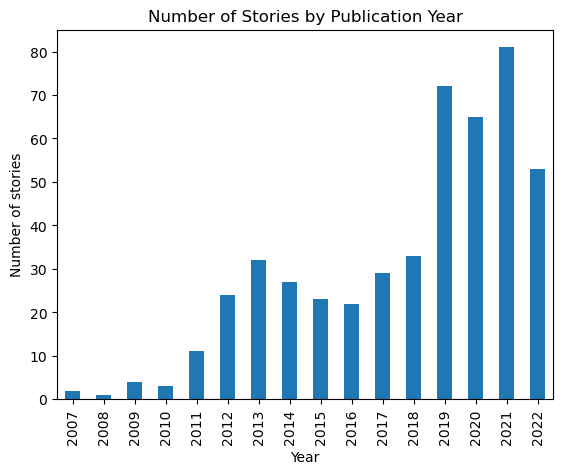

In [12]:
# it seems relevant to analyze this data in light of the absolute number of stories published each year

df_time['published'] = pd.to_datetime(df_time['published'])

df_time['year'] = df_time['published'].dt.year

counts = df_time['year'].value_counts().sort_index()

# Plot
counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of stories')
plt.title('Number of Stories by Publication Year')
plt.show()

In [13]:
# note: ChatGPT helped me create this code.
# these correlation tables are also in the Github

df_time['published'] = pd.to_datetime(df_time['published'])

# Create a month column for grouping (year-month period)
df_time['month'] = df_time['published'].dt.year # alternatively, use .to_period("M")

results = {}

for month, group in df_time.groupby('month'):
    df_numeric = group.select_dtypes(include='number')

    if len(df_numeric) < 3:  # Skip small groups with insufficient data
        continue

    # Initialize correlation and p-value DataFrames with NaNs
    correlations = pd.DataFrame(np.nan, index=df_numeric.columns, columns=df_numeric.columns)
    p_values = pd.DataFrame(np.nan, index=df_numeric.columns, columns=df_numeric.columns)

    # Calculate correlations and p-values
    for col1 in df_numeric.columns:
        for col2 in df_numeric.columns:
            if col1 != col2:
                corr, p_val = spearmanr(df_numeric[col1], df_numeric[col2])
                correlations.loc[col1, col2] = corr
                p_values.loc[col1, col2] = p_val

    alpha = 0.05
    significant_corr = correlations * (p_values < alpha)
    significant_corr = significant_corr.dropna(how='all').dropna(axis=1, how='all')

    results[str(month)] = significant_corr

# Optional: Display all significant correlations month by month
for month, corr_matrix in results.items():
    if not corr_matrix.empty:
        styled = corr_matrix.style.background_gradient(cmap="coolwarm", axis=None).format("{:.2f}")
        print(f"\nSignificant Correlations for {month}")
        display.display(styled)



/var/folders/0p/y13f3r_n4rvfvg1hjr765xnw0000gp/T/ipykernel_58187/2854798287.py:25: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_val = spearmanr(df_numeric[col1], df_numeric[col2])
/var/folders/0p/y13f3r_n4rvfvg1hjr765xnw0000gp/T/ipykernel_58187/2854798287.py:25: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_val = spearmanr(df_numeric[col1], df_numeric[col2])
/var/folders/0p/y13f3r_n4rvfvg1hjr765xnw0000gp/T/ipykernel_58187/2854798287.py:25: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_val = spearmanr(df_numeric[col1], df_numeric[col2])
/var/folders/0p/y13f3r_n4rvfvg1hjr765xnw0000gp/T/ipykernel_58187/2854798287.py:25: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_val = spearmanr(df_numeric[col1], df_numeric[col2])
/var/folders/0p/y13f3r_n4rvfvg1hjr765xnw0000


Significant Correlations for 2009


/var/folders/0p/y13f3r_n4rvfvg1hjr765xnw0000gp/T/ipykernel_58187/2854798287.py:25: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_val = spearmanr(df_numeric[col1], df_numeric[col2])


,comments,kudos,bookmarks,hits,persephone_agency,kh_ratio
comments,nan,-0.00,-0.00,0.00,-0.00,-0.00
kudos,-0.00,nan,0.00,0.00,0.00,0.00
bookmarks,-0.00,0.00,nan,0.00,0.00,0.00
hits,0.00,0.00,0.00,nan,0.00,0.00
persephone_agency,-0.00,0.00,0.00,0.00,nan,0.00
kh_ratio,-0.00,0.00,0.00,0.00,0.00,nan



Significant Correlations for 2010


,comments,kudos,bookmarks,hits,kh_ratio
comments,nan,-0.00,0.00,-0.00,0.00
kudos,-0.00,nan,0.00,-0.00,0.00
bookmarks,0.00,0.00,nan,-1.00,1.00
hits,-0.00,-0.00,-1.00,nan,-1.00
kh_ratio,0.00,0.00,1.00,-1.00,nan



Significant Correlations for 2011


,comments,kudos,bookmarks,hits,persephone_agency,hades_agency,agency_diff,hades_power,persephone_power,power_diff,kh_ratio
comments,nan,0.70,0.77,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.89
kudos,0.70,nan,0.95,0.89,0.00,0.00,0.00,0.00,-0.00,0.00,0.66
bookmarks,0.77,0.95,nan,0.80,0.00,0.62,0.00,0.00,-0.00,0.00,0.76
hits,0.00,0.89,0.80,nan,0.00,0.00,0.00,0.00,-0.00,0.00,0.00
persephone_agency,0.00,0.00,0.00,0.00,nan,0.00,0.00,-0.00,-0.00,0.00,0.00
hades_agency,0.00,0.00,0.62,0.00,0.00,nan,0.00,0.77,-0.00,0.00,0.00
agency_diff,0.00,0.00,0.00,0.00,0.00,0.00,nan,-0.00,-1.00,1.00,0.00
hades_power,0.00,0.00,0.00,0.00,-0.00,0.77,-0.00,nan,0.00,-0.00,0.00
persephone_power,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-1.00,0.00,nan,-1.00,-0.00
power_diff,0.00,0.00,0.00,0.00,0.00,0.00,1.00,-0.00,-1.00,nan,0.00



Significant Correlations for 2012


,comments,kudos,bookmarks,hits,persephone_agency,hades_agency,agency_diff,hades_power,persephone_power,power_diff,kh_ratio
comments,nan,0.62,0.70,0.47,0.00,0.00,0.00,-0.00,-0.45,-0.00,0.00
kudos,0.62,nan,0.94,0.88,0.00,0.00,0.00,-0.47,-0.00,-0.00,0.00
bookmarks,0.70,0.94,nan,0.79,0.00,0.00,0.00,-0.42,-0.00,-0.00,0.41
hits,0.47,0.88,0.79,nan,0.00,0.00,0.00,-0.50,-0.00,-0.43,-0.00
persephone_agency,0.00,0.00,0.00,0.00,nan,0.00,0.00,-0.00,-0.00,-0.00,-0.00
hades_agency,0.00,0.00,0.00,0.00,0.00,nan,0.64,-0.00,0.00,-0.47,0.00
agency_diff,0.00,0.00,0.00,0.00,0.00,0.64,nan,-0.63,-0.00,-0.79,-0.00
hades_power,-0.00,-0.47,-0.42,-0.50,-0.00,-0.00,-0.63,nan,0.00,0.80,-0.00
persephone_power,-0.45,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,nan,0.00,-0.00
power_diff,-0.00,-0.00,-0.00,-0.43,-0.00,-0.47,-0.79,0.80,0.00,nan,0.00



Significant Correlations for 2013


,comments,kudos,bookmarks,hits,persephone_agency,hades_agency,agency_diff,hades_power,persephone_power,power_diff,kh_ratio
comments,nan,0.73,0.70,0.57,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.53
kudos,0.73,nan,0.91,0.84,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.49
bookmarks,0.70,0.91,nan,0.73,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.52
hits,0.57,0.84,0.73,nan,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00
persephone_agency,0.00,0.00,0.00,0.00,nan,0.00,-0.00,-0.00,-0.00,-0.00,0.00
hades_agency,0.00,0.00,0.00,-0.00,0.00,nan,0.67,-0.00,-0.00,-0.00,0.00
agency_diff,0.00,0.00,0.00,0.00,-0.00,0.67,nan,-0.00,-0.44,0.00,0.00
hades_power,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,nan,0.00,0.54,-0.00
persephone_power,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.44,0.00,nan,-0.00,-0.00
power_diff,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.54,-0.00,nan,-0.00



Significant Correlations for 2014


,comments,kudos,bookmarks,hits,persephone_agency,hades_agency,agency_diff,hades_power,persephone_power,power_diff,kh_ratio
comments,nan,0.58,0.52,0.51,-0.00,0.00,0.00,0.00,0.00,0.00,0.00
kudos,0.58,nan,0.94,0.91,0.00,0.00,0.00,-0.00,0.00,0.00,0.61
bookmarks,0.52,0.94,nan,0.80,0.00,0.00,0.00,-0.00,0.00,0.00,0.65
hits,0.51,0.91,0.80,nan,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00
persephone_agency,-0.00,0.00,0.00,-0.00,nan,0.38,-0.00,-0.00,-0.00,-0.00,0.00
hades_agency,0.00,0.00,0.00,0.00,0.38,nan,0.00,0.00,0.00,0.00,0.00
agency_diff,0.00,0.00,0.00,0.00,-0.00,0.00,nan,0.66,-0.55,0.99,0.00
hades_power,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.66,nan,-0.39,0.69,-0.00
persephone_power,0.00,0.00,0.00,0.00,-0.00,0.00,-0.55,-0.39,nan,-0.60,-0.00
power_diff,0.00,0.00,0.00,0.00,-0.00,0.00,0.99,0.69,-0.60,nan,0.00



Significant Correlations for 2015


,comments,kudos,bookmarks,hits,persephone_agency,hades_agency,agency_diff,hades_power,persephone_power,power_diff,kh_ratio
comments,nan,0.49,0.55,0.48,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00
kudos,0.49,nan,0.95,0.91,0.00,-0.00,0.00,0.00,0.00,-0.00,0.81
bookmarks,0.55,0.95,nan,0.84,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.82
hits,0.48,0.91,0.84,nan,0.00,-0.00,-0.00,0.00,0.00,0.00,0.59
persephone_agency,0.00,0.00,-0.00,0.00,nan,0.00,-0.00,0.00,0.00,0.00,-0.00
hades_agency,-0.00,-0.00,-0.00,-0.00,0.00,nan,0.00,-0.00,0.00,-0.00,0.00
agency_diff,-0.00,0.00,0.00,-0.00,-0.00,0.00,nan,-0.00,0.71,-0.84,0.00
hades_power,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,nan,0.00,0.00,-0.00
persephone_power,-0.00,0.00,0.00,0.00,0.00,0.00,0.71,0.00,nan,-0.84,0.00
power_diff,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.84,0.00,-0.84,nan,-0.00



Significant Correlations for 2016


,comments,kudos,bookmarks,hits,persephone_agency,hades_agency,agency_diff,hades_power,persephone_power,power_diff,kh_ratio
comments,nan,0.53,0.56,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.60
kudos,0.53,nan,0.74,0.93,0.00,0.00,0.00,0.00,-0.00,0.00,0.57
bookmarks,0.56,0.74,nan,0.66,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.61
hits,0.00,0.93,0.66,nan,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00
persephone_agency,0.00,0.00,0.00,0.00,nan,0.00,-0.61,0.00,0.00,-0.61,0.00
hades_agency,-0.00,0.00,-0.00,-0.00,0.00,nan,-0.49,0.61,0.00,-0.49,0.00
agency_diff,-0.00,0.00,-0.00,0.00,-0.61,-0.49,nan,-0.61,-0.61,1.00,-0.00
hades_power,0.00,0.00,0.00,0.00,0.00,0.61,-0.61,nan,0.00,-0.61,0.00
persephone_power,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.61,0.00,nan,-0.61,0.00
power_diff,-0.00,0.00,-0.00,0.00,-0.61,-0.49,1.00,-0.61,-0.61,nan,-0.00



Significant Correlations for 2017


,comments,kudos,bookmarks,hits,persephone_agency,hades_agency,agency_diff,hades_power,persephone_power,power_diff,kh_ratio
comments,nan,0.75,0.63,0.64,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.54
kudos,0.75,nan,0.83,0.85,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.63
bookmarks,0.63,0.83,nan,0.70,0.00,0.00,-0.00,0.00,-0.00,0.00,0.49
hits,0.64,0.85,0.70,nan,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00
persephone_agency,0.00,0.00,0.00,0.00,nan,0.00,-0.00,0.00,-0.45,0.00,-0.00
hades_agency,-0.00,-0.00,0.00,-0.00,0.00,nan,0.00,-0.41,0.00,-0.00,0.00
agency_diff,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,nan,-0.62,0.00,-1.00,-0.00
hades_power,0.00,0.00,0.00,0.00,0.00,-0.41,-0.62,nan,-0.00,0.62,0.00
persephone_power,-0.00,-0.00,-0.00,-0.00,-0.45,0.00,0.00,-0.00,nan,-0.00,-0.00
power_diff,0.00,0.00,0.00,0.00,0.00,-0.00,-1.00,0.62,-0.00,nan,0.00



Significant Correlations for 2018


,comments,kudos,bookmarks,hits,persephone_agency,hades_agency,agency_diff,hades_power,persephone_power,power_diff,kh_ratio
comments,nan,0.63,0.64,0.60,-0.00,-0.00,-0.36,0.00,0.00,0.00,0.00
kudos,0.63,nan,0.87,0.84,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.42
bookmarks,0.64,0.87,nan,0.81,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00
hits,0.60,0.84,0.81,nan,0.00,-0.00,-0.41,0.00,0.00,0.00,-0.00
persephone_agency,-0.00,0.00,-0.00,0.00,nan,0.00,-0.00,-0.00,-0.00,-0.41,0.00
hades_agency,-0.00,-0.00,-0.00,-0.00,0.00,nan,0.00,-0.75,-0.00,-0.00,0.00
agency_diff,-0.36,-0.00,-0.00,-0.41,-0.00,0.00,nan,-0.00,0.00,-0.00,0.00
hades_power,0.00,-0.00,-0.00,0.00,-0.00,-0.75,-0.00,nan,0.00,0.52,-0.00
persephone_power,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,nan,0.54,0.00
power_diff,0.00,-0.00,-0.00,0.00,-0.41,-0.00,-0.00,0.52,0.54,nan,-0.00



Significant Correlations for 2019


,comments,kudos,bookmarks,hits,persephone_agency,hades_agency,agency_diff,hades_power,persephone_power,power_diff,kh_ratio
comments,nan,0.59,0.51,0.48,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.27
kudos,0.59,nan,0.77,0.80,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.48
bookmarks,0.51,0.77,nan,0.61,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.39
hits,0.48,0.80,0.61,nan,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00
persephone_agency,-0.00,0.00,0.00,0.00,nan,0.29,0.00,-0.00,-0.00,-0.31,0.00
hades_agency,-0.00,0.00,0.00,0.00,0.29,nan,0.35,-0.33,-0.00,-0.00,0.00
agency_diff,0.00,0.00,0.00,0.00,0.00,0.35,nan,0.40,-0.00,0.00,0.00
hades_power,0.00,-0.00,-0.00,-0.00,-0.00,-0.33,0.40,nan,-0.00,0.42,-0.00
persephone_power,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,nan,-0.36,0.00
power_diff,-0.00,-0.00,-0.00,-0.00,-0.31,-0.00,0.00,0.42,-0.36,nan,0.00



Significant Correlations for 2020


,comments,kudos,bookmarks,hits,persephone_agency,hades_agency,agency_diff,hades_power,persephone_power,power_diff,kh_ratio
comments,nan,0.48,0.58,0.37,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.29
kudos,0.48,nan,0.80,0.83,0.00,0.00,-0.00,-0.25,0.00,-0.00,0.42
bookmarks,0.58,0.80,nan,0.71,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00
hits,0.37,0.83,0.71,nan,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00
persephone_agency,0.00,0.00,0.00,0.00,nan,0.00,-0.50,-0.00,-0.00,-0.00,0.00
hades_agency,-0.00,0.00,0.00,0.00,0.00,nan,0.00,-0.00,-0.34,0.32,0.00
agency_diff,-0.00,-0.00,-0.00,-0.00,-0.50,0.00,nan,0.25,-0.48,0.25,-0.00
hades_power,-0.00,-0.25,-0.00,-0.00,-0.00,-0.00,0.25,nan,0.00,0.31,-0.00
persephone_power,0.00,0.00,-0.00,0.00,-0.00,-0.34,-0.48,0.00,nan,-0.50,0.00
power_diff,-0.00,-0.00,0.00,-0.00,-0.00,0.32,0.25,0.31,-0.50,nan,0.00



Significant Correlations for 2021


,comments,kudos,bookmarks,hits,persephone_agency,hades_agency,agency_diff,hades_power,persephone_power,power_diff,kh_ratio
comments,nan,0.49,0.45,0.31,0.00,-0.00,-0.00,-0.00,-0.24,0.00,0.30
kudos,0.49,nan,0.84,0.82,0.37,0.00,-0.00,-0.00,-0.00,-0.00,0.34
bookmarks,0.45,0.84,nan,0.72,0.40,0.00,-0.00,-0.00,-0.00,-0.00,0.25
hits,0.31,0.82,0.72,nan,0.29,0.00,-0.00,-0.00,-0.00,-0.00,-0.00
persephone_agency,0.00,0.37,0.40,0.29,nan,0.26,-0.00,0.00,-0.00,-0.00,0.00
hades_agency,-0.00,0.00,0.00,0.00,0.26,nan,0.29,0.50,-0.00,0.42,0.00
agency_diff,-0.00,-0.00,-0.00,-0.00,-0.00,0.29,nan,0.34,-0.00,0.79,-0.00
hades_power,-0.00,-0.00,-0.00,-0.00,0.00,0.50,0.34,nan,0.00,0.40,-0.00
persephone_power,-0.24,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,nan,-0.26,-0.00
power_diff,0.00,-0.00,-0.00,-0.00,-0.00,0.42,0.79,0.40,-0.26,nan,-0.00



Significant Correlations for 2022


,comments,kudos,bookmarks,hits,persephone_agency,hades_agency,agency_diff,hades_power,persephone_power,power_diff,kh_ratio
comments,nan,0.33,0.37,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.41
kudos,0.33,nan,0.69,0.80,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.36
bookmarks,0.37,0.69,nan,0.52,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00
hits,0.00,0.80,0.52,nan,0.00,-0.00,-0.00,0.00,0.00,-0.28,-0.00
persephone_agency,-0.00,0.00,0.00,0.00,nan,-0.00,-0.64,0.00,0.00,-0.29,0.00
hades_agency,0.00,-0.00,0.00,-0.00,-0.00,nan,0.00,0.00,0.00,0.28,0.00
agency_diff,-0.00,-0.00,-0.00,-0.00,-0.64,0.00,nan,-0.00,-0.00,0.41,-0.00
hades_power,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,nan,0.00,0.00,0.00
persephone_power,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,nan,-0.47,-0.00
power_diff,-0.00,-0.00,-0.00,-0.28,-0.29,0.28,0.41,0.00,-0.47,nan,0.00
